## Link to article

This notebook is included in the documentation, where the interactive Plotly charts show up. See:
https://pegasystems.github.io/pega-datascientist-tools/Python/articles/graph_gallery.html

# Analyzing ADM Decision Trees

With the introduction of ADM Gradient Boosting, we now support tree-based models in ADM as an alternative to the traditional Bayesian approach. In prediction studio, there is some information on the predictors, the model performance et cetera. However, it is also possible to export the trees themselves to analyze them further. This example demonstrates some of the info you can extract yourself, including a visualisation of the actual trees - which also allows you to check the exact 'path' a prediction used through each individual tree. 

On a gradient boosting model page in prediction studio, you can download an export of the model under the 'actions' button in the top right. We've also shipped an example file of a pre-built tree in the data folder, and a 'dataset' to automatically import it from the internet. That is what we will be using for this example.

## Imports

In [1]:
# These lines are only for rendering in the docs, and are hidden through Jupyter tags
# Do not run if you're running the notebook seperately

import plotly.io as pio
pio.renderers.default='notebook_connected'

import sys
sys.path.append('../../../')

import warnings
warnings.simplefilter('ignore', SyntaxWarning)

In [2]:
from pdstools import ADMTrees, datasets

## Importing your own model export
To import your own model, simply feed the path to the ADMTrees class. There are no additional parameters.

In [3]:
# ADMTrees("path/to/model_download.json")

For this example we will use the shipped example dataset, which you can simply import with the following line:

In [4]:
Trees = datasets.SampleTrees()

## Exploring the ADMTrees class

The raw export has quite a lot of information stored in it, which is not all easily accessible. For example, looking at the 'properties' attribute, we can see the configuration of the model.

In [5]:
Trees.properties

{'factoryKey': {'configPartition': {'partition': {'pyClassName': 'Data-Decision-Request-Customer',
    'pyPurpose': 'WebClickthroughAGB'}},
  'modelPartition': {'partition': {}}},
 'configuration': {'_serialClass': 'com.pega.decision.adm.client.config.GradientBoostModelRuleConfiguration',
  '_serialVersionNumber': 2,
  'configurationId': {'configurationName': 'WebClickthroughAGB',
   'appliesToClass': 'Data-Decision-Request-Customer',
   'isPredictiveModel': False},
  'ruleSet': {'ruleSetName': 'CDHSample-Artifacts',
   'ruleSetVersion': '01-01-01'},
  'predictors': [{'name': 'Account.DaysSinceOpened', 'type': 'numeric'},
   {'name': 'Account.CurrentDateInt', 'type': 'numeric'},
   {'name': 'Customer.IsCustomerActive', 'type': 'symbolic'},
   {'name': 'Account.YTDPayments', 'type': 'numeric'},
   {'name': 'Customer.HealthMatter', 'type': 'symbolic'},
   {'name': 'Customer.LastReviewedDate', 'type': 'numeric'},
   {'name': 'Account.YTDBrokenPromises', 'type': 'numeric'},
   {'name': 'Cu

Most of this information is not particularly useful - but for example, you can find the maximum numbef of trees, the maximum depth of the trees and the outcome to label mapping. Information about the predictors is also stored here, which is extracted in the 'predictors' attribute.

In [6]:
Trees.predictors

{'Account.DaysSinceOpened': 'numeric',
 'Account.CurrentDateInt': 'numeric',
 'Customer.IsCustomerActive': 'symbolic',
 'Account.YTDPayments': 'numeric',
 'Customer.HealthMatter': 'symbolic',
 'Customer.LastReviewedDate': 'numeric',
 'Account.YTDBrokenPromises': 'numeric',
 'Customer.NetWealth': 'numeric',
 'Customer.MilitaryService': 'symbolic',
 'Account.DelinquencyAmount': 'numeric',
 'Customer.IsPrimary': 'symbolic',
 'Account.Role': 'symbolic',
 'Customer.NextReviewDate': 'symbolic',
 'Account.type': 'numeric',
 'Param.JourneyStage': 'symbolic',
 'Param.DaysinCurrentStage': 'numeric',
 'Account.InArrears': 'symbolic',
 'Account.PaymentNetwork': 'symbolic',
 'Account.AverageYearlyBalance': 'numeric',
 'Customer.AnnualIncome': 'numeric',
 'Account.YTDOverLimit': 'numeric',
 'Account.BonusMet': 'symbolic',
 'Account.CreditLine': 'numeric',
 'Customer.LanguagePreference': 'symbolic',
 'Param.Journey': 'symbolic',
 'Customer.RelationshipLengthDays': 'numeric',
 'Customer.ReviewDate': '

Naturally, the raw trees are stored here too. They are stored in the 'model' attribute, in a list with each tree in json format. Let's look at a single tree.

In [7]:
Trees.model[18]

{'score': -0.04167241398182543,
 'gain': 4.903114150998753,
 'split': 'IH.MISSING.MISSING.Churned.pyHistoricalOutcomeCount < 1.0',
 'left': {'score': 0.0015912192864844406,
  'gain': 4.921074965276381,
  'split': 'IH.SMS.Outbound.Accept.pxLastGroupID is Missing',
  'left': {'score': 0.08708304261596726, 'gain': 0.0},
  'right': {'score': -0.19378256055857698, 'gain': 0.0}},
 'right': {'score': -0.07898210064649579,
  'gain': 2.609510949104644,
  'split': 'IH.SMS.Outbound.Accept.pyHistoricalOutcomeCount < 1.0',
  'left': {'score': -0.050025939043392705,
   'gain': 5.284463037230109,
   'split': 'pyName in { PremierChecking }',
   'left': {'score': 0.3483628622864736, 'gain': 0.0},
   'right': {'score': -0.08596541739325182, 'gain': 0.0}},
  'right': {'score': 0.22697292002283817, 'gain': 0.0}}}

Each node has a 'score': the contribution to the final score, over all trees. Non-leaf nodes naturally have splits, which are expressed as a string. These can be inequality, equality or set splits. For example, we may see a split on Age being smaller than 42, but also pyName being one of {P1, P2, P3, P4, P6}. If this split evaluates to True, we follow the tree to the left node. Naturally, if it evaluates to False we follow to the right node. Lastly, each split also has a gain. This describes how well that split discriminates by splitting to the left and right nodes. 

Later we will revisit this tree structure, because for visualisation we need to slightly reformat it. But first, by nature of a boosting algorithm, looking at a single tree does not provide enough information to fully understand the model. For this, there are some properties of the ADMTrees class to look across trees. To start, we can call TreeStats to get an overview of the contribution of each tree to the final model.

In [8]:
Trees.treeStats.sample(5)

treeID,score,depth,nsplits,gains,meangains
i64,f64,i64,i64,list[f64],f64
16,-0.054558,7,24,"[2.37261, 33.652215, … 4.996202]",4.405897
32,-0.020759,5,11,"[0.765811, 3.200115, … 6.065802]",2.871456
30,-0.020792,9,54,"[0.241267, 0.201133, … 4.775513]",1.808099
26,-0.020984,9,31,"[1.641452, 3.552476, … 5.603293]",3.817874
45,-0.021229,6,21,"[1.769291, 0.060404, … 6.155768]",2.153862


In TreeStats, the index is the 'ID' of the tree, based on its position in the order of the 'model' attribute. The score corresponds to the score of the top-level node of that tree, and the 'depth' and 'nsplits' describe how deep the tree is, and how many splits are performed in total. For each split, the gain is added to the list in the 'gains' column. The mean of all splits in a tree is computed in the 'meangains' column.

Some info about individual trees is also stored in attributes, such as the splits and gains for each tree.

In [9]:
print(Trees.splitsPerTree[18])
print(Trees.gainsPerTree[18])

['IH.MISSING.MISSING.Churned.pyHistoricalOutcomeCount < 1.0', 'IH.SMS.Outbound.Accept.pxLastGroupID is Missing', 'IH.SMS.Outbound.Accept.pyHistoricalOutcomeCount < 1.0', 'pyName in { PremierChecking }']
[4.903114150998753, 4.921074965276381, 2.609510949104644, 5.284463037230109]


## Variables
Now, if we are interested in the contribution and distribution of the splits per variable, we can look at the raw data in the groupedGainsPerSplit attribute, which returns a DataFrame, grouped by the split. In the 'gains' column you see a list of all of the gains produced by this split, and the 'n' column says how often this split is performed.

In [10]:
Trees.groupedGainsPerSplit

split,predictor,gains,mean,sign,values,n
str,str,list[list[f64]],f64,str,object,u32
"""pyName in { Au…","""pyName""","[[177.064524, 95.262737, … 6.283781]]",58.111616,"""in""","{'FirstMortgageFloat', 'FirstMortgage30yr', 'MoneyMarketSavingsAccount', 'PlatinumRewardsCard', 'ProsAndConsOfFixedRate', 'GetAPersonalizedRateQuoteToday', 'AutoUsed84Months', 'PremiumBanking', 'CreditMonitoringService', 'MasterCardWorld', 'IndividualRetirementAccountsIRA', 'Earn2xRewardsPoints', 'PremierChecking', 'AMEXPersonal', 'IdentityTheftProtection', 'IncreaseYourCreditLine', 'FirstMortgage', 'VisaGold', 'PaymentProtection', 'UFixedRateMortgage', 'MasterCardGold', 'AutoUsed36Months', 'UPlusGold', 'BasicChecking', 'AutoUsed48Months', 'FirstMortgageFiveOneARM', 'SignupForRewardsCard', 'HomeOwners', 'SuperSaver', 'UPlusProductBundles', 'AutoNew60Months', 'FirstMortgageSevenOneARM', 'AutoNew84Months', 'CompleteYourCardApplicationToday', 'StudentChoice'}",1
"""pyName in { Au…","""pyName""","[[1102.556954, 153.075758, … 2.770062]]",144.75059,"""in""","{'FirstMortgageFloat', 'FirstMortgage30yr', 'PlatinumRewardsCard', 'ProsAndConsOfFixedRate', 'GetAPersonalizedRateQuoteToday', 'AutoUsed84Months', 'PremiumBanking', 'CreditMonitoringService', 'MasterCardWorld', 'IndividualRetirementAccountsIRA', 'Earn2xRewardsPoints', 'AMEXPersonal', 'IdentityTheftProtection', 'IncreaseYourCreditLine', 'FirstMortgage', 'VisaGold', 'PaymentProtection', 'UFixedRateMortgage', 'MasterCardGold', 'AutoUsed36Months', 'UPlusGold', 'AutoUsed48Months', 'FirstMortgageFiveOneARM', 'SignupForRewardsCard', 'HomeOwners', 'SuperSaver', 'UPlusProductBundles', 'AutoNew60Months', 'FirstMortgageSevenOneARM', 'AutoNew84Months', 'CompleteYourCardApplicationToday', 'StudentChoice'}",1
"""pyName in { UP…","""pyName""","[[3.648124, 5.092834, … 1.945262]]",3.336998,"""in""",{'UPlusGold'},1
"""pyName in { Au…","""pyName""","[[1.687369, 3.857415, … 2.235231]]",1.985773,"""in""","{'FirstMortgageFloat', 'FirstMortgage30yr', 'PlatinumRewardsCard', 'AutoUsed84Months', 'PremiumBanking', 'MasterCardWorld', 'Earn2xRewardsPoints', 'AMEXPersonal', 'IncreaseYourCreditLine', 'FirstMortgage', 'VisaGold', 'MasterCardGold', 'AutoUsed36Months', 'UPlusGold', 'AutoUsed48Months', 'FirstMortgageFiveOneARM', 'HomeOwners', 'SuperSaver', 'UPlusProductBundles', 'AutoNew60Months', 'FirstMortgageSevenOneARM', 'AutoNew84Months', 'CompleteYourCardApplicationToday', 'StudentChoice'}",1
"""IH.Web.Inbound…","""IH.Web.Inbound…","[[5.216521, 9.372519, 4.885585]]",6.491542,"""<""",{'0.9332044675925926'},1
"""Customer.Annua…","""Customer.Annua…",[[11.029298]],11.029298,"""<""",{'27048.0798438366'},1
"""Customer.Age <…","""Customer.Age""","[[0.997894, 1.239415, … 1.954151]]",5.42389,"""<""",{'55.0'},1
"""Customer.Relat…","""Customer.Relat…","[[4.262478, 6.598286]]",5.430382,"""<""",{'51.0'},1
"""Customer.Annua…","""Customer.Annua…","[[7.9857, 4.48732, 0.212923]]",4.228648,"""<""",{'50896.2577184401'},1


Raw data is sometimes useful, but it's better to visualise. For this, simply call plotSplitsPerVariable(), which will produce a plot of the distribution of splits for each variable. Here, the orange line denotes the number of times the given split is performed, while the blue boxes display the distribution of gains corresponding to that split. By suppling a set of predictors as the 'subset' argument, not all predictors are plotted. For readability's sake, we've filtered only on a few specific splits.

**Note 1:** Given that the gains can differ drastically between splits, some plots may not be very useful as-is. However, since they are Plotly plots they are interactive: hover over the data to see the raw numbers, and select a region within the plot to zoom in.
**Note 2:** For categorical splits especially, the axis labels are typically not very readable. Even while hovering, there may be too much information. This is simply by nature of these splits. In this case, it may be more useful to look at the raw data in the groupedGainsPerSplit dataframe.

In [11]:
preds = ['Customer.Age', 'Customer.LanguagePreference', 'pyName']
Trees.plotSplitsPerVariable(subset=preds);

## Visualising the trees

With the provided tree structures, it is also possible to visualise each tree individually. While of course each individual tree is used for scoring and thus one tree is on average only 1/50th of the total contribution, this still provides useful information of the inner workings of the algorithm. In the background, we transform the raw tree structure to a node and edges-based json structure, where each node gets an ID, and their child and parent nodes are linked

In [12]:
Trees.getTreeRepresentation(18)

{1: {'score': -0.04167241398182543,
  'gain': 4.903114150998753,
  'split': 'IH.MISSING.MISSING.Churned.pyHistoricalOutcomeCount < 1.0',
  'left_child': 2,
  'right_child': 5},
 2: {'score': 0.0015912192864844406,
  'parent_node': 1,
  'gain': 4.921074965276381,
  'split': 'IH.SMS.Outbound.Accept.pxLastGroupID is Missing',
  'left_child': 3,
  'right_child': 4},
 3: {'score': 0.08708304261596726, 'parent_node': 2, 'gain': 0.0},
 4: {'score': -0.19378256055857698, 'parent_node': 2, 'gain': 0.0},
 5: {'score': -0.07898210064649579,
  'parent_node': 1,
  'gain': 2.609510949104644,
  'split': 'IH.SMS.Outbound.Accept.pyHistoricalOutcomeCount < 1.0',
  'left_child': 6,
  'right_child': 9},
 6: {'score': -0.050025939043392705,
  'parent_node': 5,
  'gain': 5.284463037230109,
  'split': 'pyName in { PremierChecking }',
  'left_child': 7,
  'right_child': 8},
 7: {'score': 0.3483628622864736, 'parent_node': 6, 'gain': 0.0},
 8: {'score': -0.08596541739325182, 'parent_node': 6, 'gain': 0.0},
 9:

Then, we can visualise the tree as such:

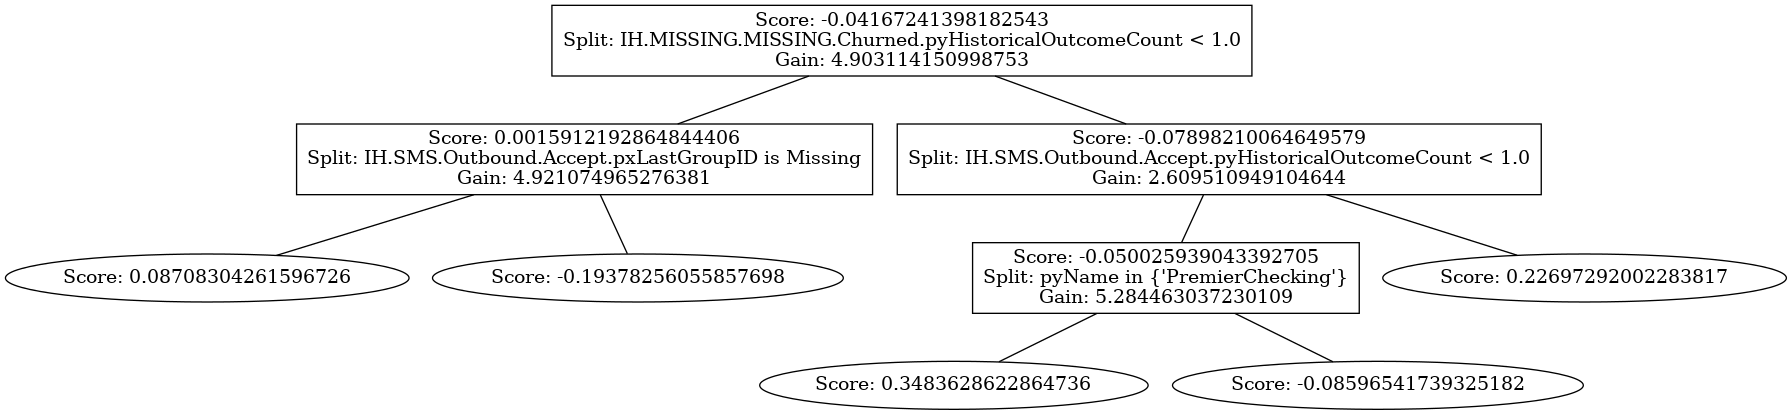

In [13]:
Trees.plotTree(18);

## Plot prediction path

With this tree, of course we can also show how a tree would score a set of input data 'x'. Simply pass a dictionary with variable:value pairs to plotTree's "highlighted" parameter, and that path is highlighted:

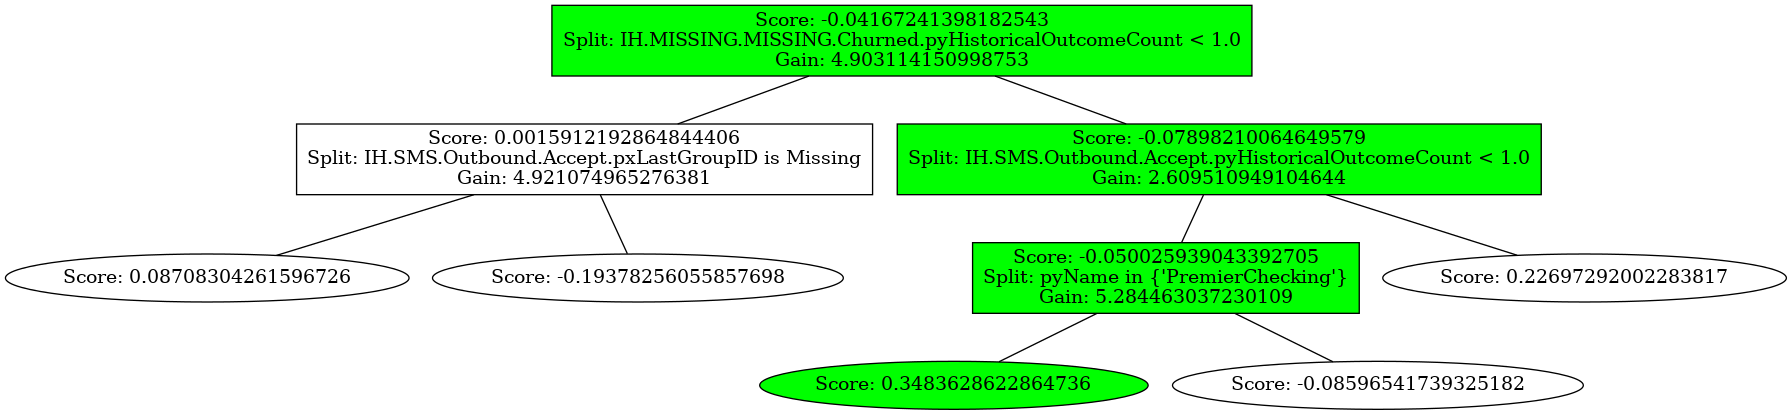

In [14]:
Trees.plotTree(18, highlighted = {"IH.MISSING.MISSING.Churned.pyHistoricalOutcomeCount":2, "IH.SMS.Outbound.Accept.pyHistoricalOutcomeCount":0, "pyName": 'PremierChecking'});

Of course that also works if we define x first and then feed that as the highlighted parameter.

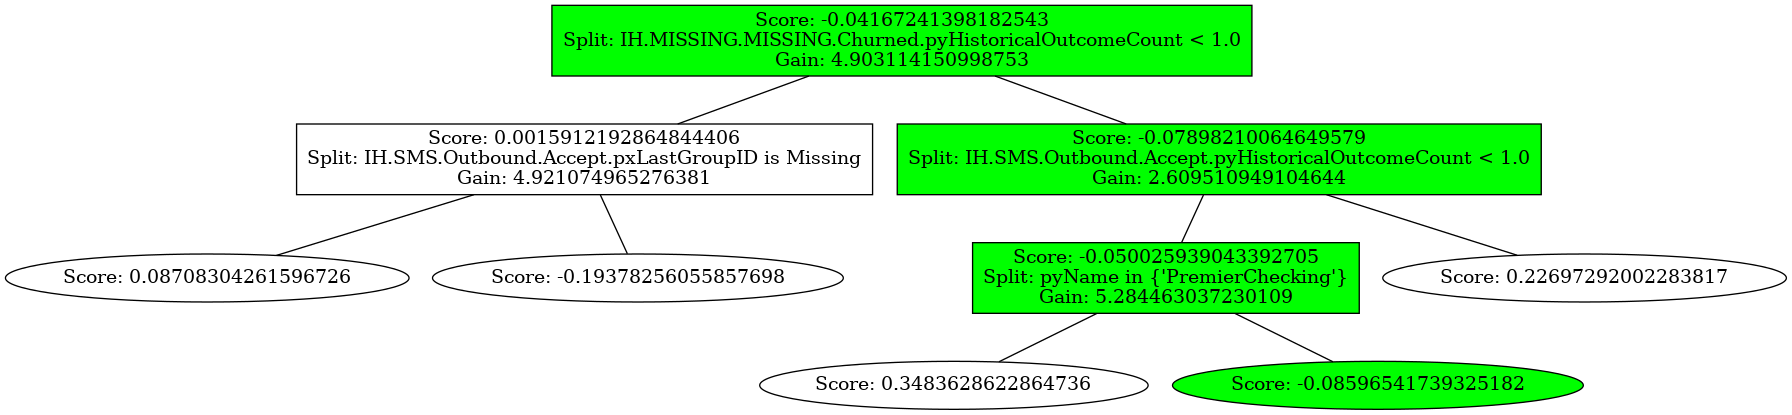

In [15]:
x = {"IH.MISSING.MISSING.Churned.pyHistoricalOutcomeCount":2, "IH.SMS.Outbound.Accept.pyHistoricalOutcomeCount":0, "pyName": 'NotPremierChecking'}
Trees.plotTree(18, highlighted=x);

Thus far we've only look at tree 18, but of course we can plot different trees as well. This is also where these visualisations aren't always as useful, because the trees can get quite large and hard to read:

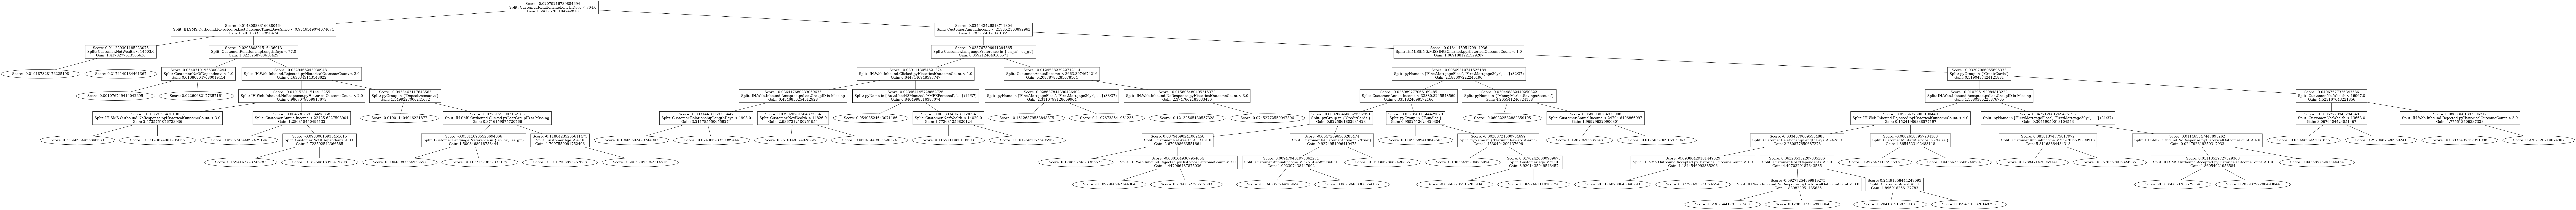

In [16]:
Trees.plotTree(30);

Note it is possible to export these trees by calling functions on the raw model, such as 'write_png' or 'write_pdf':

```python
Trees.plotTree(4, highlighted=x).write_png('Tree.png')
Trees.plotTree(4, highlighted=x).write_pdf('Tree.pdf')
```

#### Random input data
For this demo, I want to generate some random input parameters, so a quick function to do that is this:

In [17]:
def sampleX(trees):
    from random import sample
    x = {}
    for variable, values in trees.allValuesPerSplit.items():
        if len(values) == 1:
            if 'true' in values or 'false' in values:
                values = {'true', 'false'}
            if isinstance(list(values)[0], str):
                try: 
                    float(list(values)[0])
                except:
                    values = values.union({'Other'})
        x[variable]= sample(list(values), 1)[0]
    return x
randomX = sampleX(Trees)

## Replicating scores
Lastly, with a given x and each scoring tree both stored, we can replicate the score the models would give to that customer by simply letting each tree predict a score. By calling 'getAllVisitedNodes', we get an overview of all visited nodes, each split that was performed and the scores contributed by each individual tree. By default this is sorted by their scores. This also gives us an idea of the relative 'importance' of each tree for the final prediction. 

In [18]:
scores = Trees.getAllVisitedNodes(randomX)
scores

treeID,visited_nodes,score,splits
i64,list[i64],f64,str
0,"[1, 11, … 23]",-0.269231,"""[{'pyName in {…"
1,"[1, 21, 23]",-0.464293,"""[{'pyGroup in …"
2,"[1, 21, 29]",-0.172585,"""[{'pyName in {…"
3,"[1, 11, … 45]",-0.027471,"""[{'pyName in {…"
4,"[1, 49, 51]",-0.118753,"""[{'pyName in {…"
5,"[1, 23, … 44]",-0.037658,"""[{'pyName in {…"
6,"[1, 21, … 31]",-0.27716,"""[{'pyGroup in …"
7,"[1, 2, 8]",0.106033,"""[{'pyName in {…"
8,"[1, 23, … 77]",-0.28831,"""[{'pyGroup in …"


Now, to get to the final score we simply sum up the scores, and then normalize them to a range between 0 and 1:

In [19]:
import math
1/(1+math.exp(-scores['score'].sum()))

0.20509751674836557

And to simplify this even further, simply call the 'score' function to get the final score.

In [20]:
Trees.score(randomX)

0.20509751674836557

Finally, we can also plot the contribution of each tree towards the final propensity of the prediction. Simply call the plotContributionPerTree function with a given x. This shows, for each individual tree, the scores, the cumulative mean of those scores and the running propensity. Here you can clearly see that the average score is quite negative, so as we would expect the final propensity is also quite low.

In [21]:
Trees.plotContributionPerTree(randomX);

These are the current features of the ADMTrees class. As always, if you have suggestions, please do not hesitate to open a GitHub issue or pull request!